In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Reference Data

## Run Data

In [2]:
def better_mask_for(a, b):
    sa = np.sum(a, axis=-1)
    sb = np.sum(b, axis=-1)
    return sa > sb

def max_diff_for(a, b):
    sa = np.sum(a, axis=-1)
    sb = np.sum(b, axis=-1)
    
    diff = sa-sb
    min_diff = np.min(diff)
    max_diff = np.max(diff)
    
    min_pos = np.amin(diff)
    max_pos = np.amax(diff)
    
    print("min", min_diff, "max", max_diff)
    
    return diff.astype("float"), min_diff, max_diff, min_pos, max_pos

# which of the above graph's points protrude further
def maximum_qs(qs_list):
    best = np.zeros_like(qs_list[0])
    
    for qs in qs_list:
        better_mask = better_mask_for(qs, best)
        best[better_mask] = qs[better_mask]
        
    return best

In [3]:
import glob, re
import itertools, operator

### All Graphs

### Cat Codes

## Plot

In [4]:
from mpl_toolkits.mplot3d.art3d import Line3D

In [5]:
def reference_points(qs_best):
    # dep
    dep = min(qs_best, key=lambda a: (a[0]-a[1])**2 + (a[1]-a[2])**2 + (a[2]-a[0])**2)
    dep = dep.mean()
    dep1 = np.linspace(dep, dep*1.8, 2)
    dep1 = [dep1, dep1, dep1]
    dep2 = np.linspace(0, dep, 2)
    dep2 = [dep2, dep2, dep2]
    
    # 2pauli
    paul = min(qs_best, key=lambda a: (a[0]-a[2])**2 + a[1]**2)
    paul = (paul[0] + paul[2])/2
    paul1 = np.linspace(paul, paul*1.8, 2)
    paul1 = [paul1, np.zeros_like(paul1), paul1]
    paul2 = np.linspace(0, paul, 2)
    paul2 = [paul2, np.zeros_like(paul2), paul2]
    
    # bb84
    bb84 = min(qs_best, key=lambda a: (a[0]-a[2])**2 + ((a[0] + a[1])**2 - a[1])**2)
    bb84 = math.sqrt(bb84[1])
    bb841 = np.linspace(bb84, bb84*1.8, 20)
    bb841 = [bb841-bb841**2, bb841**2, bb841-bb841**2]
    bb842 = np.linspace(0, bb84, 20)
    bb842 = [bb842-bb842**2, bb842**2, bb842-bb842**2]
    
    return [
        (dep1, dep2),
        (paul1, paul2),
        (bb841, bb842)
    ]

In [6]:
# nonlinear color transformation around midpoint
from matplotlib.colors import SymLogNorm
color_mapper = SymLogNorm(linthresh=.00008, linscale=.00008, vmin=-.1, vmax=.1)

In [7]:
viridis = cm.get_cmap('Spectral')

In [8]:
data_ref = np.load("./volumes/single-letter-kSys1-kEnvMax1.lambdas.tar.gz-best.npz")
data_single_letter = data_ref["qs"]

In [22]:
def plot(qs_competitor, title, qs_ref=data_single_letter):
    fig = plt.figure(figsize=(12, 10), facecolor='white')
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=30, azim=22)
    
    ax.set_xlabel("q1")
    ax.set_ylabel("q2")
    ax.set_zlabel("q3")

    ax.set_xlim(0, .5)
    ax.set_ylim(0, .5) 
    ax.set_zlim(0, .5)

    
    # surface plot
    qs_best = maximum_qs([qs_competitor, qs_ref])
    diff, min_diff, max_diff, min_pos, max_pos = max_diff_for(qs_competitor, qs_ref)

    q1,q2,q3 = qs_competitor.transpose() # qs_best.transpose()
    ax.scatter(q1, q2, q3, marker=".", c=viridis(color_mapper(diff)), zorder=-1)
    
      
    
    # reference lines
    for line_fg, line_bg in reference_points(qs_best):
        ax.add_line(Line3D(*line_fg, color="black", alpha=1, zorder=3, linestyle="--"))
        ax.add_line(Line3D(*line_bg, color="black", alpha=.4, zorder=3, linestyle="--"))


    # colorbar
    colorbar_map = plt.cm.ScalarMappable(cmap=viridis, norm=color_mapper)
    colorbar_map.set_array([-.5, .5])
    colorbar_map.set_clim([-.5, .5])
    plt.colorbar(colorbar_map,
                 ticks=[-.1, -.01, -.001, .0, .001, .01, .1, min_diff, max_diff],
                 fraction=0.046,
                 pad=0.2
                )
    
    
    plt.tight_layout()
    plt.title(title + f", min: {round(min_diff, 4)}, max: {round(max_diff, 4)}")
    plt.show()

In [23]:
files = [(fn, int(re.findall(r"kSys(\d+)", fn)[0])) for fn in glob.glob("./volumes/all-graphs*.npz")]
print(files)
all_graph_data = {}
for (fn, kSys) in files:
    if not kSys in all_graph_data: all_graph_data[kSys] = []
    all_graph_data[kSys].append(np.load(fn)["qs"])
for key in all_graph_data:
    all_graph_data[key] = maximum_qs(all_graph_data[key])

[('./volumes/all-graphs-IRKHO===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IRCWW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IROXO===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IRCXW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IRDHW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IQ7XW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IRBXW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-INDA====-kSys4-kEnvMax4.lambdas.tar-best-ppkTotMax8.npz', 4), ('./volumes/all-graphs-IRKXO===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-INPA====-kSys4-kEnvMax4.lambdas.tar-best-ppkTotMax8.npz', 4), ('./volumes/all-graphs-IRPHW===-kSys5-kEnvMax5.lambdas.tar-best-ppkTotMax8.npz', 5), ('./volumes/all-graphs-IRKVO===-kSys5-kEnvMax5.lambdas.tar-best-

In [55]:
files = glob.glob("./volumes/concat*1-in-43*best.npz")
print(files)
concatcodes_data = []
for fn in files:
    concatcodes_data.append(np.load(fn)["qs"])
concatcodes_data = maximum_qs(concatcodes_data)

['./volumes/concatcodes.Pj5zcGFyc2U2PDw6a19PR0NBQD9fT0dDQUA-X09HQ0FAP19PR0NBQD9fT0dDQUA-X09HQ0FAP19PR0NBQD9fXn5+fn5+Cg==.1-in-43.gz.lambdas.tar.gz-best.npz']


min -0.20445799153710079 max 0.28132245229659475


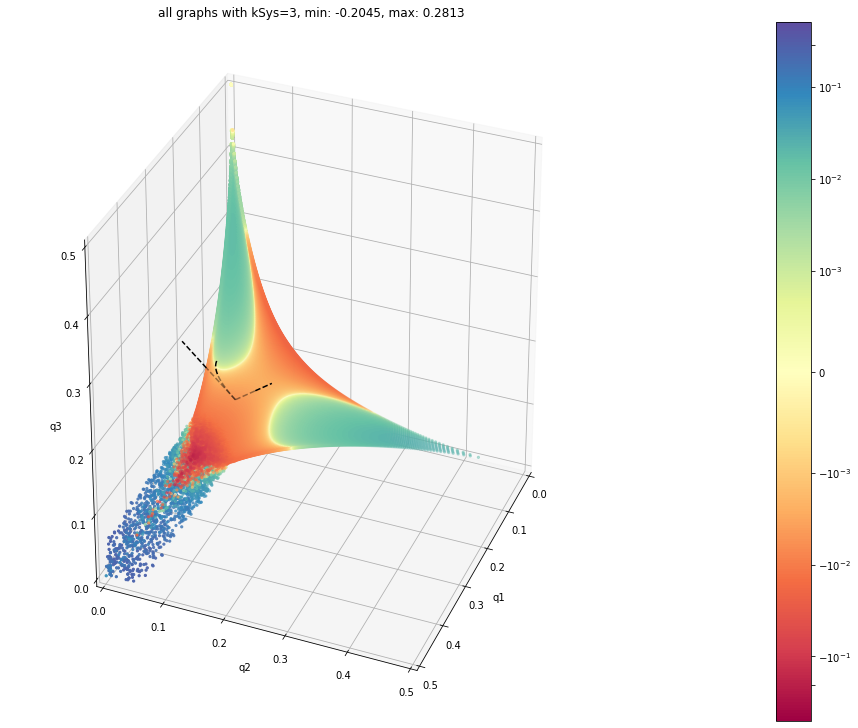

In [56]:
plot(concatcodes_data, "all graphs with kSys=3")